In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import zipfile
import os
if not os.path.exists('10_food_classes_10_percent.zip'):
  !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
  zip = zipfile.ZipFile('10_food_classes_10_percent.zip')
  zip.extractall()
  zip.close()
else:
  print('file alraedy exists')

--2023-12-25 10:44:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.3MB/s    in 8.3s    

2023-12-25 10:44:13 (19.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
walk = list(os.walk('10_food_classes_10_percent'))

# Exploring our directories
for filepath,directories,imgs in walk:
  print(f'There are {len(directories)} Directories and {len(imgs)} imgaes in the {filepath}')

labels_list = walk[1][1]
labels_list.sort()
print(labels_list)

There are 2 Directories and 0 imgaes in the 10_food_classes_10_percent
There are 10 Directories and 0 imgaes in the 10_food_classes_10_percent/train
There are 0 Directories and 75 imgaes in the 10_food_classes_10_percent/train/chicken_wings
There are 0 Directories and 75 imgaes in the 10_food_classes_10_percent/train/sushi
There are 0 Directories and 75 imgaes in the 10_food_classes_10_percent/train/grilled_salmon
There are 0 Directories and 75 imgaes in the 10_food_classes_10_percent/train/chicken_curry
There are 0 Directories and 75 imgaes in the 10_food_classes_10_percent/train/hamburger
There are 0 Directories and 75 imgaes in the 10_food_classes_10_percent/train/fried_rice
There are 0 Directories and 75 imgaes in the 10_food_classes_10_percent/train/ice_cream
There are 0 Directories and 75 imgaes in the 10_food_classes_10_percent/train/ramen
There are 0 Directories and 75 imgaes in the 10_food_classes_10_percent/train/steak
There are 0 Directories and 75 imgaes in the 10_food_clas

In [4]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.,
                                                                 rotation_range=0.2,
                                                                 width_shift_range=0.2,
                                                                 height_shift_range=0.2,
                                                                 shear_range=0.2,
                                                                 zoom_range=0.2)
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)


train_data = train_data_gen.flow_from_directory(directory = '10_food_classes_10_percent/train',
                                                target_size=(224,224),
                                                class_mode = 'categorical',
                                                batch_size = 32)

test_data = test_data_gen.flow_from_directory(directory = '10_food_classes_10_percent/test',
                                              target_size=(224,224),
                                              class_mode='categorical',
                                              batch_size=32)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


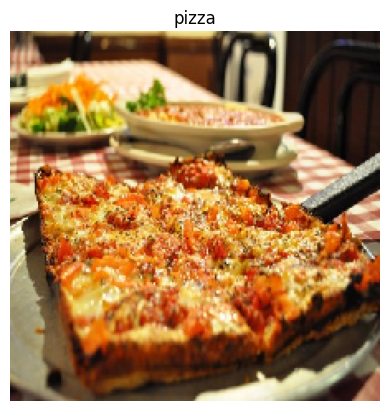

In [85]:
# Visualize our data
batch,img = np.random.randint(0,750//32),np.random.randint(0,32)

plt.imshow(test_data[batch][0][img])
plt.axis('off')
label = np.argmax(test_data[batch][1][img])
plt.title(labels_list[label])
plt.show()

### Tensorflow callbacks:
- Tracking Experiments with => TensorBoad()
- Model Checkpoint => Model CheckPointing()
- Stopping model trainning (avoid trainning for too long, avoid overfitting) => EarlyStopping()

In [6]:
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving tensorboard for {log_dir}")
  return tensorboard_callback



In [14]:
# Creating models using tensorflow hub

# !pip install --upgrade tensorflow_hub
import tensorflow_hub as hub

In [15]:
def define_model(model_url,classes_number):
  model = tf.keras.Sequential([
      hub.KerasLayer(model_url,trainable=False),
      tf.keras.layers.Dense(classes_number, activation='softmax')
  ])
  model.build([None, 224, 224, 3])
  return model



In [88]:
model_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1"
classes_number = 10
!rm -r models_results
model_1 = define_model(model_url,classes_number)
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = "Adam",
              metrics = ['accuracy'])
model_1.fit(train_data,validation_data=test_data,epochs=5,callbacks = [create_tensorboard_callback('models_results','effNet')])

rm: cannot remove 'models_results': No such file or directory
Saving tensorboard for models_results/effNet20231225-120353
Epoch 1/5
24/24 [==============================] - 33s 874ms/step - loss: 1.9273 - accuracy: 0.3773 - val_loss: 1.3891 - val_accuracy: 0.7124
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 1.2222 - accuracy: 0.7227 - val_loss: 0.9493 - val_accuracy: 0.8060
Epoch 3/5
24/24 [==============================] - 26s 1s/step - loss: 0.9186 - accuracy: 0.7920 - val_loss: 0.7521 - val_accuracy: 0.8320
Epoch 4/5
24/24 [==============================] - 21s 891ms/step - loss: 0.7675 - accuracy: 0.8187 - val_loss: 0.6573 - val_accuracy: 0.8440
Epoch 5/5
24/24 [==============================] - 35s 2s/step - loss: 0.6576 - accuracy: 0.8533 - val_loss: 0.5979 - val_accuracy: 0.8480


In [89]:
model_url = "https://www.kaggle.com/models/tensorflow/resnet-50/frameworks/TensorFlow2/variations/feature-vector/versions/1"
classes_number = 10

model_2 = define_model(model_url,classes_number)
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = "Adam",
              metrics = ['accuracy'])
model_2.fit(train_data,validation_data=test_data,epochs=5,callbacks = [create_tensorboard_callback('models_results','resNet')])

Saving tensorboard for models_results/resNet20231225-120649
Epoch 1/5
24/24 [==============================] - 36s 1s/step - loss: 2.0221 - accuracy: 0.3307 - val_loss: 1.1923 - val_accuracy: 0.6072
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.9920 - accuracy: 0.6920 - val_loss: 0.7605 - val_accuracy: 0.7544
Epoch 3/5
24/24 [==============================] - 20s 845ms/step - loss: 0.6975 - accuracy: 0.7827 - val_loss: 0.6540 - val_accuracy: 0.7868
Epoch 4/5
24/24 [==============================] - 22s 917ms/step - loss: 0.6010 - accuracy: 0.8387 - val_loss: 0.6005 - val_accuracy: 0.8100
Epoch 5/5
24/24 [==============================] - 20s 865ms/step - loss: 0.4852 - accuracy: 0.8640 - val_loss: 0.5549 - val_accuracy: 0.8240


In [97]:
model_1.save('effnet.keras')

In [98]:
model_2.save('rasnet.keras')

#### Transfer Learning types:
- **As is**: Using pre-existing model without changing it (ResNet, EfficientNet) with its output layers 1000 classes..
- **Feature Extraction**: Make some adjustment for the model eg. changing output layer to fit our problem (10 activations in the output layer)
- **Fine Tunning**: Transfer Learning: using pre-existing model and fine tune the underline layers uncluding new output layer

In [99]:
# Visualize results using tensor board

!tensorboard dev upload --logdir ./modules_results/ --name "EffNet vs ResNet" --description "Studing the difference between 2 pretrained models" --one_shot

2023-12-25 12:36:32.788492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-25 12:36:32.788549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-25 12:36:32.790216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-25 12:36:33.860996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb